#### データの全体像
train：1,482,535個のユーザーが投稿した商品

test：693,359行で「価格（Price）」の項目がテストデータは含まれていないため、列数は「7」となっている 

* train_id / test _id – ユーザー投稿のID
* name – 投稿のタイトル。タイトルに価格に関する情報がある場合（例：$20）はメルカリが事前に削除をして[rm]と置き換えている。
* item_condition_id – ユーザーが指定した商品の状態(1~5,大きい方が状態が良い)
* category_name – 投稿カテゴリー
* brand_name – ブランドの名前
* price – 訓練データのみ。実際に売られた価格。米ドル表示。今回のチャレンジの予測ターゲットとなる。
* shipping – 送料のフラグ。「1」は販売者負担。「0」は購入者負担。
* item_description – ユーザーが投稿した商品説明の全文。タイトルと同様に価格情報がある場合は[rm]と置き換えられている。

In [1]:
from datetime import datetime
start_real = datetime.now() # 全体の処理時間の計測を開始する

#### ライブラリのインポート

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import Ridge

import gc
import warnings
warnings.simplefilter("ignore")

#### データの読み込み

In [3]:
%%time
# train = pd.read_csv("/kaggle/input/mercari-dataset/train.tsv", delimiter='\t')
# test = pd.read_csv("/kaggle/input/mercari-dataset/test.tsv", delimiter='\t')
train = pd.read_csv("train.tsv", delimiter='\t')
test = pd.read_csv("test.tsv", delimiter='\t')

CPU times: user 3.37 s, sys: 300 ms, total: 3.67 s
Wall time: 3.7 s


In [4]:
#trainのpriceで3ドル未満の割合
print("3ドル以下の割合", train[train["price"] < 3].shape[0] / train.shape[0])
#3ドル未満のデータを削除
train = train.drop(train[train["price"] < 3].index)

#train["price"]で範囲別の割合
print("3-10ドルの割合", train[train["price"] < 10].shape[0] / (train.shape[0]*0.01))
print("3-20ドルの割合", train[train["price"] < 20].shape[0] / (train.shape[0]*0.01))
print("3-30ドルの割合", train[train["price"] < 30].shape[0] / (train.shape[0]*0.01))
print("3-40ドルの割合", train[train["price"] < 40].shape[0] / (train.shape[0]*0.01))
print("3-50ドルの割合", train[train["price"] < 50].shape[0] / (train.shape[0]*0.01))
print("3-60ドルの割合", train[train["price"] < 60].shape[0] / (train.shape[0]*0.01))
print("3-70ドルの割合", train[train["price"] < 70].shape[0] / (train.shape[0]*0.01))
print("3-80ドルの割合", train[train["price"] < 80].shape[0] / (train.shape[0]*0.01))
print("3-90ドルの割合", train[train["price"] < 90].shape[0] / (train.shape[0]*0.01))
print("3-100ドルの割合", train[train["price"] < 100].shape[0] / (train.shape[0]*0.01))
print("3-150ドルの割合", train[train["price"] < 150].shape[0] / (train.shape[0]*0.01))
print("3-250ドルの割合", train[train["price"] < 250].shape[0] / (train.shape[0]*0.01))
print("3-2000ドルの割合", train[train["price"] < 2000].shape[0] / (train.shape[0]*0.01))

3ドル以下の割合 0.0005895307699312327
3-10ドルの割合 18.64117365578226
3-20ドルの割合 56.20617671653637
3-30ドルの割合 75.1545731445992
3-40ドルの割合 84.15096300705761
3-50ドルの割合 89.24497574006469
3-60ドルの割合 92.29661845725843
3-70ドルの割合 94.25678343426735
3-80ドルの割合 95.49195126280573
3-90ドルの割合 96.42084120456703
3-100ドルの割合 97.00923490596027
3-150ドルの割合 98.624516674192
3-250ドルの割合 99.56494771746033
3-2000ドルの割合 99.9993925736049


#### データの前処理

In [5]:
# 変更点4 3ドル以上2000ドル以下のデータのみを使用する -0.0042
train = train[(train["price"] >= 3) & (train["price"] <= 2000)]

#### `price`を対数変換

In [6]:
%%time
train['price'] = np.log1p(train['price'])
print(train['price'].describe())

count    1.481658e+06
mean     2.980807e+00
std      7.458991e-01
min      1.386294e+00
25%      2.397895e+00
50%      2.890372e+00
75%      3.401197e+00
max      7.601402e+00
Name: price, dtype: float64
CPU times: user 36.2 ms, sys: 3.29 ms, total: 39.5 ms
Wall time: 38.7 ms


In [7]:
#変更点4　217万点中1万点削除 -0.0052
#母数217万点に対して、category_nameの1万点は少ないからmissingに置き換えず、単純にdrop
train.dropna(subset=['category_name'], inplace=True)
test.dropna(subset=['category_name'], inplace=True)

#### `category_name`を3等分する

In [8]:
%%time
def split_cat(text):
    try: return text.split("/")
    except: return ("No Label", "No Label", "No Label") # メモ: たとえば null としたらスコアは変化する？

train['general_cat'] = train['category_name'].apply(lambda x: split_cat(x)[0])
train['sub_cat1'] = train['category_name'].apply(lambda x: split_cat(x)[1])
train['sub_cat2'] = train['category_name'].apply(lambda x: split_cat(x)[2])
display(train.head())

test['general_cat'] = test['category_name'].apply(lambda x: split_cat(x)[0])
test['sub_cat1'] = test['category_name'].apply(lambda x: split_cat(x)[1])
test['sub_cat2'] = test['category_name'].apply(lambda x: split_cat(x)[2])
display(test.head())

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,sub_cat1,sub_cat2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,2.397895,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,3.970292,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,2.397895,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,3.583519,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,3.806662,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,general_cat,sub_cat1,sub_cat2
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7,Women,Jewelry,Rings
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",Other,Office supplies,Shipping Supplies
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...,Vintage & Collectibles,Bags and Purses,Handbag
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...,Women,Sweaters,Cardigan
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...,Other,Books,Religion & Spirituality


CPU times: user 1.2 s, sys: 50.2 ms, total: 1.25 s
Wall time: 1.25 s


#### train, test を行方向に結合し、まとめて前処理できるようにする

In [9]:
y = train['price'] # 目的変数
train.drop(['price'], axis=1, inplace=True)

# 列名をidに変更
train.rename(columns={'train_id': 'id'}, inplace=True)
test.rename(columns={'test_id': 'id'}, inplace=True)

# データフレームを結合
train_test_combine = pd.concat([train,test]) # axis=0で行、axis=1で列に結合 デフォルトはaxis=0
print(train_test_combine.shape)
train_test_combine.head()

(2165645, 10)


,id,name,item_condition_id,category_name,brand_name,shipping,item_description,general_cat,sub_cat1,sub_cat2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


#### 欠損値処理


In [10]:
train_test_combine.isnull().sum()

id                        0
name                      0
item_condition_id         0
category_name             0
brand_name           922755
shipping                  0
item_description          4
general_cat               0
sub_cat1                  0
sub_cat2                  0
dtype: int64

In [11]:
%%time
# 欠損値を 'missing'で埋める
# メモ: null にしたらスコアは変化する？ missingと意味は同じだから変わらない
train_test_combine['brand_name'].fillna(value='missing', inplace=True)
train_test_combine['category_name'].fillna(value='missing', inplace=True)
train_test_combine['item_description'].fillna(value='missing', inplace=True)

CPU times: user 117 ms, sys: 2.78 ms, total: 119 ms
Wall time: 119 ms


In [15]:
#変更点4 ブランドリストあり -0.0041
#brand_nameの重複なしのリストを作成
brand_name_list = set(train_test_combine["brand_name"].values) #set()で重複を削除
def brandfinder(line):
    brand = line[0] # 第1要素はブランド名
    name = line[1]  # 第2要素は商品名
    namesplit = name.split(' ') # 商品名をスペースで切り分ける
    
    if brand == 'missing':  # ブランド名が'missing'の場合
        for x in namesplit: # 商品名から切り分けた単語を取り出す
            if x in brand_name_list: # 単語がブランドリストに存在すればブランド名を返す              
                return x # 単語がブランドリストに一致したら商品名を返す  変更点3 name(商品名全体)を返すのではなく、x(ブランド名)のみを返す
    if name in brand_name_list:  # 商品名がブランドリストに存在すれば商品名を返す
        return name
    
    return brand            # どれにも一致しなければブランド名を返す

# ブランド名の付替えを実施
train_test_combine['brand_name'] = train_test_combine[['brand_name','name']].apply(brandfinder, axis = 1) #axis=1で行方向

#brandfinderの中身
train_test_combine[['brand_name','name']].head(10)

,brand_name,name
0,MLB,MLB Cincinnati Reds T Shirt Size XL
1,Razer,Razer BlackWidow Chroma Keyboard
2,Target,AVA-VIV Blouse
3,missing,Leather Horse Statues
4,missing,24K GOLD plated rose
5,missing,Bundled items requested for Ruie
6,Acacia Swimwear,Acacia pacific tides santorini top
7,Soffe,Girls cheer and tumbling bundle of 7
8,Nike,Girls Nike Pro shorts
9,missing,Porcelain clown doll checker pants VTG


In [16]:
# ベクトル化（カウントやTF-IDF）およびエンコーディング（ONE-HOT）の前にメモリをクリアしておく
gc.collect()

1169

#### 特徴エンコーディング｜CountVectorizer(), TfidfVectorizer()

**`name`に CountVectorizer を使用する理由**
- **短いテキスト**: 商品名は通常短いテキストで、単語の出現回数が直接的な特徴として有用であることが多い。
- **単純な頻度**: 単語の出現頻度を重視することで、商品名の違いを強調できる。

**`item_description`に TfidfVectorizer を使用する理由**
- **長いテキスト**: 商品説明は通常長めで、単語数が多く、情報量が多い。
- **重要度の重み付け**: TF-IDFは、頻出しすぎる単語の影響を抑え、より重要な単語に重みを置く。これにより、商品説明内の特徴的な情報を抽出しやすくなる。
- **n-gram考慮**: n-gramを使うことで、単語の組み合わせが持つ特徴も捉えることができる。

in', 'no', 'put', 'her', 'it', 'ltd', 'not', 'two', 'etc', 'via', 'has', 'we', 'an', 'can', 'own', 'be', 'yet', 'i', 'but', 'up', 're', 'its', 'off', 'if', 'nor', 'of', 'as', 'so', 'eg', 'to', 'you', 'is', 'go', 'may'とかがストップワード

In [17]:
%%time
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(train_test_combine['name'])

tfidf = TfidfVectorizer(max_features = 50000, ngram_range= (1,3) , stop_words='english')
X_descp = tfidf.fit_transform(train_test_combine['item_description'])

print('name vectorization shape:',X_name.shape)
print('item_description vectorization shape:',X_descp.shape)

name vectorization shape: (2165645, 130463)
item_description vectorization shape: (2165645, 50000)
CPU times: user 1min 41s, sys: 6.34 s, total: 1min 48s
Wall time: 1min 49s


## PCAで次元削減(スコア上がらないからコメントアウト)

In [18]:
# #tf-idfでベクトル化したnameとitem_descriptionをPCAで次元削減
# from sklearn.decomposition import PCA

# def pca_reduce(input_df: pd.Series, col_prefix: str=None, n_components: int=2):
#     """PCAで圧縮
#     """
#     _prefix = "pca"
#     if col_prefix:
#         _prefix = col_prefix + '_' + _prefix
#     columns=[_prefix + f'_{i:03}' for i in range(n_components)]
#     return pd.DataFrame(
#             PCA(n_components=n_components).fit_transform(input_df),
#             columns=columns,
#         )

# # nameとitem_descriptionをPCAで次元削減
# X_name = pca_reduce(X_name, col_prefix='name', n_components=524)  #次元数
# X_descp = pca_reduce(X_descp, col_prefix='descp', n_components=200)

In [19]:
# print('name vectorization shape:',X_name.shape)
# print('item_description vectorization shape:',X_descp.shape)

## TF-IDFの代わりにWord2Vecを使用(スコア上がらないからコメントアウト)

In [20]:
# !pip uninstall -y scipy
# !pip install scipy
# !pip uninstall -y gensim
# !pip install gensim

In [21]:
#TF-IDFの代わりにWord2Vecを使用
# # ライブラリのインポート
# from gensim.models import Word2Vec
# from sklearn.preprocessing import scale

# # データの前処理
# sentences = train_test_combine['item_description'].apply(lambda x: x.split())

# # Word2Vecモデルのトレーニング
# word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# # ベクトル化関数の定義
# def build_word_vector(text, size):
#     vec = np.zeros(size).reshape((1, size))
#     count = 0
#     for word in text:
#         try:
#             vec += word2vec_model.wv[word].reshape((1, size))
#             count += 1
#         except KeyError:  # Word2Vecモデルに存在しない単語は無視
#             continue
#     if count != 0:
#         vec /= count
#     return vec

# # 商品説明をベクトル化
# X_descp = np.concatenate([build_word_vector(z, 100) for z in sentences])
# X_descp = scale(X_descp)

# print('item_description vectorization shape:', X_descp.shape)

#### 特徴エンコーディング｜OneHotEncoder()

#### `brand_name`に CountVectorizer() や TfidfVectorizer() ではなく OneHotEncoder() を使う理由

1. **カテゴリデータの性質**:
   - `brand_name`は通常、固有名詞で構成されるカテゴリデータである。
   - 単語の頻度や重要度ではなく、単純なカテゴリとして扱うのが適切である。

2. **OneHotEncoderの適用**:
   - 各ブランドを個別のカテゴリとしてエンコードし、独立した特徴量に変換する。
   - この方法により、ブランド間の違いを明確にモデルに示すことができる。

3. **CountVectorizerやTfidfVectorizerの不適性**:
   - これらはテキストデータの単語頻度や重要度を計算するための手法であり、カテゴリデータの単純な区別には向いていない。

#### `item_condition_id`や`shipping`に OneHotEncoder() を適用する理由は、これらのデータがカテゴリデータとして扱われるべきだからである。

1. **カテゴリデータとしての扱い**:
   - これらの変数は整数型だが、実際にはカテゴリ的な意味合いを持つ。
   - 例えば、`item_condition_id`は商品の状態を表すカテゴリであり、数値の大小に意味はない。

2. **モデルへの影響**:
   - 数値のまま扱うと、モデルはそれらに順序や距離の情報があると誤解する可能性がある。
   - ワンホットエンコーディングにより、各カテゴリを独立した特徴量として扱うことで、誤解を防ぐ。

3. **情報の独立性**:
   - 各条件や配送方法を独立した特徴量にすることで、モデルが個別の影響を学習しやすくなる。

In [22]:
%%time
ohe = OneHotEncoder()

# OneHotEncoderは2次元の入力を必要とするため、.reshape(-1, 1)で1次元のSeriesを2次元に変換
X_brand_name = ohe.fit_transform(train_test_combine['brand_name'].values.reshape(-1, 1))
X_item_condition_id = ohe.fit_transform(train_test_combine['item_condition_id'].values.reshape(-1, 1))
X_shipping = ohe.fit_transform(train_test_combine['shipping'].values.reshape(-1, 1))
X_general_cat = ohe.fit_transform(train_test_combine['general_cat'].values.reshape(-1, 1))
X_sub_cat1 = ohe.fit_transform(train_test_combine['sub_cat1'].values.reshape(-1, 1))
X_sub_cat2 = ohe.fit_transform(train_test_combine['sub_cat2'].values.reshape(-1, 1))

CPU times: user 1.2 s, sys: 152 ms, total: 1.35 s
Wall time: 1.35 s


In [23]:
print('brand encoding shape:', X_brand_name.shape)
print('item condition id encoding shape:', X_item_condition_id.shape)
print('shipping encoding shape:', X_shipping.shape)
print('general_cat encoding shape:', X_general_cat.shape)
print('sub_cat1 encoding shape:', X_sub_cat1.shape)
print('sub_cat2 encoding shape:', X_sub_cat2.shape)

brand encoding shape: (2165645, 5265)
item condition id encoding shape: (2165645, 5)
shipping encoding shape: (2165645, 2)
general_cat encoding shape: (2165645, 10)
sub_cat1 encoding shape: (2165645, 113)
sub_cat2 encoding shape: (2165645, 882)


#### 特徴ベクトル化されたスパース行列とワンホットエンコードされたスパース行列を結合する

このコードは、データを訓練用とテスト用に分割し、各特徴量を結合して疎行列（sparse matrix）を作成している。

1. **データ分割**:
   - `1482535`は訓練データとテストデータを分けるインデックス。
   - `[:1482535]`は訓練データの範囲。
   - `[1482535:]`はテストデータの範囲。

2. **特徴量の結合**:
   - `hstack()`を使用して各特徴量の行列を水平に結合。
   - 結果として、全ての特徴量が一つの大きな行列として表現される。

3. **疎行列（sparse matrix）**:
   - `tocsr()`は、行圧縮形式（Compressed Sparse Row format）で格納。
   - メモリ効率が良く、大規模データに適している。

4. **ターゲット変数**:
   - `y_train`は訓練データのターゲット変数を格納。

**エンコーディングする前の列は説明変数に加えない**  
情報の重複と多重共線性のリスクを避けるためである。エンコーディングされたデータは元のテキストデータの情報を包含しているため、元の列を残すと過剰な情報がモデルの性能を低下させる可能性がある。

In [24]:
print(train.shape)

(1475344, 10)


In [29]:
%%time
combined_matrix_train = (X_name[:1475344], X_descp[:1475344], X_brand_name[:1475344], X_item_condition_id[:1475344], X_shipping[:1475344],
                   X_general_cat[:1475344], X_sub_cat1[:1475344], X_sub_cat2[:1475344])
X = hstack(combined_matrix_train).tocsr() # 説明変数

combined_matrix_test = (X_name[1475344:], X_descp[1475344:], X_brand_name[1475344:], X_item_condition_id[1475344:], X_shipping[1475344:],
                   X_general_cat[1475344:], X_sub_cat1[1475344:], X_sub_cat2[1475344:])
test = hstack(combined_matrix_test).tocsr()

CPU times: user 445 ms, sys: 626 ms, total: 1.07 s
Wall time: 1.15 s


In [30]:
print(X.shape) # 説明変数
print(test.shape)

(1475344, 186740)
(690301, 186740)


#### モデルの作成と学習

#### X と y のうち、7割を訓練用 (train)、3割を検証用 (test) に分割する

In [31]:
print(f"Length of X: {X.shape[0]}")
print(f"Length of y: {len(y)}")

Length of X: 1475344
Length of y: 1475344


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [33]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1032740, 186740)
(1032740,)
(442604, 186740)
(442604,)


## Optuna

#### モデルの学習｜Ridge回帰

In [35]:
# 変更点4 Optunaで90回の最適化を実行する -0.0076
!pip install optuna
import optuna
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_log_error

# RMSLE関数の定義
def rmsle(y_true, y_pred):
    # クリップして無限大や非常に大きな値を避ける
    y_true_clipped = np.clip(y_true, 0, np.log(np.finfo(np.float64).max))
    y_pred_clipped = np.clip(y_pred, 0, np.log(np.finfo(np.float64).max))
    
    return np.sqrt(mean_squared_log_error(y_true_clipped, y_pred_clipped))

def objective(trial):
    # ハイパーパラメータの設定
    alpha = trial.suggest_loguniform('alpha', 1e-3, 1e+2)  # 正則化パラメータ
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    solver = trial.suggest_categorical('solver', ['auto','lsqr','sparse_cg'])
    random_state = trial.suggest_int('random_state', 0, 100)

    # モデルの定義
    model = Ridge(
        alpha=alpha,
        fit_intercept=fit_intercept,
        solver=solver,
        random_state=random_state
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return rmsle(y_test, y_pred)

study = optuna.create_study(direction='minimize')
# 最適化の実行
study.optimize(objective, n_trials=10)

print(study.best_params)  # 最適なパラメータ

[I 2024-09-29 12:03:52,052] A new study created in memory with name: no-name-d2a74cfd-da4d-49d0-b674-518b1ef4ab23
[I 2024-09-29 12:04:23,955] Trial 0 finished with value: 0.11852176279506652 and parameters: {'alpha': 0.0366937195083305, 'fit_intercept': True, 'solver': 'lsqr', 'random_state': 40}. Best is trial 0 with value: 0.11852176279506652.
[I 2024-09-29 12:04:55,692] Trial 1 finished with value: 0.11866074270417655 and parameters: {'alpha': 0.011113789790960032, 'fit_intercept': True, 'solver': 'lsqr', 'random_state': 56}. Best is trial 0 with value: 0.11852176279506652.
[I 2024-09-29 12:06:12,063] Trial 2 finished with value: 0.11765057942716783 and parameters: {'alpha': 0.2329945880967567, 'fit_intercept': True, 'solver': 'auto', 'random_state': 8}. Best is trial 2 with value: 0.11765057942716783.
[I 2024-09-29 12:06:24,136] Trial 3 finished with value: 0.11563902040062556 and parameters: {'alpha': 10.497156028495988, 'fit_intercept': True, 'solver': 'lsqr', 'random_state': 16}

{'alpha': 4.467610217326253, 'fit_intercept': True, 'solver': 'lsqr', 'random_state': 99}


### optuna 50回最適化
{'alpha': 5.026270314898842, 'fit_intercept': True, 'solver': 'lsqr', 'random_state': 35}
### optuna 100回最適化
{'alpha': 4.5554246746989415, 'fit_intercept': True, 'solver': 'auto', 'random_state': 24}

## Grid search(スコア上がらないからコメントアウト)

In [34]:
# # 必要なライブラリのインポート
# import numpy as np
# from sklearn.linear_model import Ridge
# from sklearn.metrics import mean_squared_log_error
# from sklearn.model_selection import GridSearchCV

# # RMSLE関数の定義
# def rmsle(y_true, y_pred):
#     y_true_clipped = np.clip(y_true, 0, np.log(np.finfo(np.float64).max))
#     y_pred_clipped = np.clip(y_pred, 0, np.log(np.finfo(np.float64).max))
#     return np.sqrt(mean_squared_log_error(y_true_clipped, y_pred_clipped))

# # ハイパーパラメータの設定
# param_grid = {
#     'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
#     'fit_intercept': [True, False],
#     'solver': ['auto', 'lsqr', 'sparse_cg'],
#     'random_state': [0, 42, 100]
# }

# # モデルの定義
# model = Ridge()

# # GridSearchCVの設定
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_log_error', cv=5, n_jobs=-1) #50回のクロスバリデーション

# # モデルのトレーニング
# grid_search.fit(X_train, y_train)

# # 最適なパラメータの表示
# print("Best parameters found: ", grid_search.best_params_)


## ランダムサーチ(スコア上がらないからコメントアウト)

In [35]:
# # 必要なライブラリのインポート
# import numpy as np
# from sklearn.linear_model import Ridge
# from sklearn.metrics import mean_squared_log_error
# from sklearn.model_selection import RandomizedSearchCV

# # RMSLE関数の定義
# def rmsle(y_true, y_pred):
#     y_true_clipped = np.clip(y_true, 0, np.log(np.finfo(np.float64).max))
#     y_pred_clipped = np.clip(y_pred, 0, np.log(np.finfo(np.float64).max))
#     return np.sqrt(mean_squared_log_error(y_true_clipped, y_pred_clipped))

# # ターゲットデータの負の値を0にクリップ
# y_train_clipped = np.clip(y_train, 0, None)
# y_test_clipped = np.clip(y_test, 0, None)

# # ハイパーパラメータの設定
# param_distributions = {
#     'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
#     'fit_intercept': [True, False],
#     'solver': ['auto', 'lsqr', 'sparse_cg'],
#     'random_state': np.random.randint(0, 11, size=10)  # 0から100の間でランダムに選ぶ
# }

# # モデルの定義
# model = Ridge()

# # RandomizedSearchCVの設定（施行回数を30回に設定） 100回だと150分かかる
# random_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, scoring='neg_mean_squared_log_error', n_iter=10, cv=5, random_state=42)

# # モデルのトレーニング
# random_search.fit(X_train, y_train_clipped)

# # 最適なパラメータの表示
# print("Best parameters found: ", random_search.best_params_)

In [ ]:
# {'alpha': 4.467610217326253, 'fit_intercept': True, 'solver': 'lsqr', 'random_state': 99}

In [36]:
# %%time
ridge = Ridge(solver="lsqr", fit_intercept=True, random_state=99,alpha=4.467610217326253) #今までの最適化前のパラメータ
# ridge = Ridge(alpha=4.5554246746989415, fit_intercept=True, solver='auto', random_state=24) #変更点4 最適化後のパラメータ Optunaのbest_paramを代入して
ridge.fit(X_train, y_train)

Ridge(alpha=4.467610217326253, random_state=99, solver='lsqr')

#### 訓練データに対する予測｜Ridge回帰

In [37]:
y_train_pred = ridge.predict(X_train)

In [38]:
y_min = np.append(y_train_pred, y_train).min()
y_max = np.append(y_train_pred, y_train).max()
y_margin = (y_max - y_min) * 0.1
y_min -= y_margin
y_max += y_margin

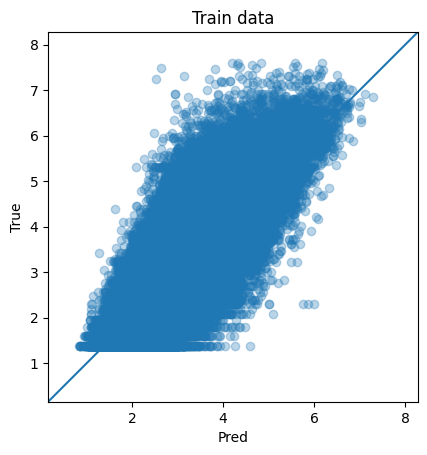

In [39]:
plt.scatter(y_train_pred, y_train, alpha=0.3)
plt.plot([y_min,y_max], [y_min,y_max])
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(y_min, y_max)
plt.ylim(y_min, y_max)
plt.title('Train data')
plt.xlabel('Pred')
plt.ylabel('True')
plt.show()

In [40]:
# RMSLE関数の定義
def rmsle(y_true, y_pred):  
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [41]:
# モデルの評価
ridge_train_rmsle = rmsle(np.expm1(y_train), np.expm1(y_train_pred))
print("RMSLE for train data:", ridge_train_rmsle)

RMSLE for train data: 0.43086020704262584


#### テストデータに対する予測｜Ridge回帰

In [42]:
y_test_pred = ridge.predict(X_test)

In [43]:
y_min = np.append(y_test_pred, y_test).min()
y_max = np.append(y_test_pred, y_test).max()
y_margin = (y_max - y_min) * 0.1
y_min -= y_margin
y_max += y_margin

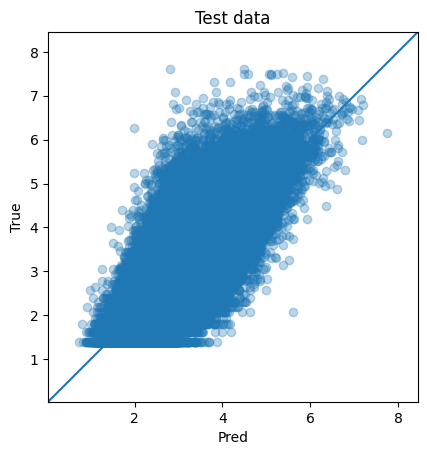

In [44]:
plt.scatter(y_test_pred, y_test, alpha=0.3)
plt.plot([y_min,y_max], [y_min,y_max])
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(y_min, y_max)
plt.ylim(y_min, y_max)
plt.title('Test data')
plt.xlabel('Pred')
plt.ylabel('True')
plt.show()

In [45]:
# モデルの評価
ridge_test_rmsle = rmsle(np.expm1(y_test), np.expm1(y_test_pred))
print("RMSLE for test data:", ridge_test_rmsle)

RMSLE for test data: 0.45961817077198835


In [46]:
stop_real = datetime.now()
execution_time_real = stop_real - start_real
print(execution_time_real)

0:16:32.565547
